# Iris Flower Species Prediction

## 1.0 Introduction

### 1.1 Business Understanding / Project Objective

The objective of the project is to build a machine learning model that predicts the species of an iris flower when given the lengths and widths of the flower's sepals and petals.

This challenge is part of the requirements for the SLightly Techie community.

### 1.2 Data Understanding

The dataset contains ... The columns in the dataset are described below:

- *sepal_length*: the length of the flower's sepals
- *sepal_width*: the width of the flower's sepals
- *petal_length*: the length of the flower's petals
- *petal_width*: the width of the flower's petals
- *species*: the specie of the flower

## 2.0 Toolbox Loading

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")  # Hiding the warnings

# Modelling
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import *
import lightgbm as lgb
from catboost import CatBoostClassifier

# Additional libraries
import sweetviz as sv
import os
import pickle


print("Loading complete.", "Warnings hidden.")

Loading complete. Warnings hidden.


In [2]:
# Removing the restriction on columns to display
pd.set_option("display.max_columns", None)

## 3.0 Data Exploration

In [3]:
# Loading the data
dataset = pd.read_csv("data/IRIS.csv")
dataset

sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

In [4]:
# Looking at information about the columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
# Checking for duplicates
dataset[dataset.duplicated()]

sepal_length  sepal_width  petal_length  petal_width         species
34            4.9          3.1           1.5          0.1     Iris-setosa
37            4.9          3.1           1.5          0.1     Iris-setosa
142           5.8          2.7           5.1          1.9  Iris-virginica

From the dataset preview and the info above, we note the following:
- There are a total of 150 observations in the dataset
- There are no missing values in any of the columns
- There are 3 duplicates in the dataset, but they will not be removed due to the size of the dataset.
- All the other columns excluding the species column have numeric values.
- There are 3 species (the target variable); the column wil have to be encoded before modelling.

In [6]:
# Profiling the dataset with SweetViz
my_report = sv.analyze(dataset)
my_report.show_html("src/original_data_profile.html")

                                             |          | [  0%]   00:00 -> (? left)

Report src/original_data_profile.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 3.1 Exploration of Numeric Columns

*What is the distribution of the columns with numeric values? Are there any outliers?*

In [7]:
# Looking at the descriptive statistics of the columns with numeric values
numerics = [column for column in dataset.columns if (dataset[column].dtype != "O") & (len(dataset[column].unique()) > 2)]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
dataset[numerics].describe()

Summary table of the Descriptive Statistics of Columns with Numeric Values


sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In [8]:
# Visualizing the distributions of the columns with numeric values
for column in dataset[numerics].columns:
    if len(dataset[column].unique()) > 2:

        # Visualizing the distribution of categories inside the column
        fig = px.box(dataset[numerics], y=column, labels={"color": "species"},
                     title=f"A visual representation of values in the {column} column"
                    )
        fig.show()

        # Visualizing the proportion of the species inside the column
        fig = px.box(dataset[numerics], y=column, color=dataset["species"], labels={"color": "species"},
                     title=f"A visual representation of values in the {column} column split by species"
                     )
        fig.show()

The following may be noted from the statistical summary table and the boxplots:

**sepal_length**
- The values range from 4.3 - 7.9 cm, with both the mean and median being close at 5.84 cm and 5.80 respectively.
- When grouped by species, we notice that the setosa species have the shortest sepal lengths, followed by versicolor, and then virginica, in that order.

**sepal_width**
- The range of the values is 2.0 - 4.4 cm, with the mean and median at 3.05 cm and 3.0 cm respectively
- Despite featuring some outliers, 50% of the flowers have a sepal width between 2.8 and 3.3 cm.
- When spilt by species, we note that setosas generally have the widest spread of sepal width (2.3 - 4.4 cm), while versicolors have 2 - 3.4 cm, and virginicas generally have 2.2 - 3.8 cm. 
- From the boxplot, we see that setosas generally have longer sepal widths than both versicolor and virginica

**petal_length**
- The petal lengths in the dataset range from 1.0 - 6.9 cm. The difference between the mean (3.76cm) and the median (4.35) may be an indication of significant differences between the observations. This is supported by the standard deviation of 1.76 cm.
- Ranging from 1 - 1.9 cm, setosas have the least petal lengths across the 3 species. They are followed by versicolor (3 - 5.1 cm) whose petal lengths overlap with virginica (4.5 - 6.9 cm).

**petal_width**
- The petal widths range from 0.1 - 2.5 cm, with a standard deviation of 0.76 cm. The mean and the median stand at 1.2 cm and 1.3 cm respectively.
- Here too, setosas have the shortest petal widths (0.1 - 0.6 cm) even with outliers. They are followed by versicolor (1 - 1.8 cm), and then virginica (1.4 - 2.5 cm) with some overlaps in width.

### 3.2 Exploration of Categorical Columns

In [9]:
# Visualizing the distribution of the columns with categorical values and their species
categoricals = [column for column in dataset.columns if (
    dataset[column].dtype == "O")]

for column in dataset[categoricals].columns:
    # Visualizing the distribution of the categories in the column
    fig = px.histogram(dataset, x=dataset[column], text_auto=True,
                       title=f"Distribution of values in the {column} column")
    fig.show()

Here are some observations on the categorical columns with regard to the charts:


## 4.0 Feature Engineering
### 4.1 Feature Encoding

In [10]:
# Looking at the number of unique values in each column
dataset.nunique()

sepal_length    35
sepal_width     23
petal_length    43
petal_width     22
species          3
dtype: int64

- Here, the target column - with three unique values - will be encoded using label encoding.
- The other columns will be scaled before modelling since they are all numeric.

In [11]:
# Encoding the species column
dataset["species"].replace({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}, inplace=True)
dataset

sepal_length  sepal_width  petal_length  petal_width  species
0             5.1          3.5           1.4          0.2        0
1             4.9          3.0           1.4          0.2        0
2             4.7          3.2           1.3          0.2        0
3             4.6          3.1           1.5          0.2        0
4             5.0          3.6           1.4          0.2        0
..            ...          ...           ...          ...      ...
145           6.7          3.0           5.2          2.3        2
146           6.3          2.5           5.0          1.9        2
147           6.5          3.0           5.2          2.0        2
148           6.2          3.4           5.4          2.3        2
149           5.9          3.0           5.1          1.8        2

[150 rows x 5 columns]

### 4.2 Feature Correlation and Selection

In [12]:
# Looking at the correlation between the variables in the merged dataframe
correlation = pd.DataFrame(dataset.corr())

# Defining a colourscale for the correlation plot
colorscale = [[0.0, "rgb(255,255,255)"], [0.2, "rgb(255, 255, 153)"],
              [0.4, "rgb(153, 255, 204)"], [0.6, "rgb(179, 217, 255)"],
              [0.8, "rgb(240, 179, 255)"], [1.0, "rgb(255, 77, 148)"]
              ]

# Plotting the Correlation Matrix
fig = px.imshow(correlation,
                text_auto=".3f",
                aspect="auto",
                labels={"color": "Correlation Coefficient"},
                contrast_rescaling="minmax",
                color_continuous_scale=colorscale
                )
fig.update_xaxes(side="top")
fig.show()

The correlation matrix presents a more comprehensive view on the nature of the relationships between the various variables in the dataset, where we see that:
- petal_length has a very strong positive correlation with petal_width
- sepal_length has a strong positive correlation with both petal_length and petal_width
- sepal_width is negatively correlated with all the other variables including the target variable
- Due to the limited number of features, none of them will be dropped prior to modelling.

## 5.0 Modelling

**Preview**
- Train_test_split: Modelling will be done normally with a basic train_test_split. The selected model will then be cross-validated and fine-tuned before completion.
- Balancing: since all the categories in the target column have the same number of observations (no minority class), there will be no balancing of observations

In [13]:
# Defining the target & predictor variables
X = dataset.drop(columns=["species"])
y = dataset["species"]

# Splitting the dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [14]:
# Scale the numeric columns
scaler = MinMaxScaler()
X_train[numerics] = scaler.fit_transform(X_train[numerics])
X_test[numerics] = scaler.transform(X_test[numerics])

### 5.1 Logistic Regression

In [15]:
# Logistic Regression
log_reg = LogisticRegression(random_state=24)
log_reg_model = log_reg.fit(X_train,  y_train)

# Feature Importance of the Random Forest Model
log_reg_importance = log_reg_model.coef_[0]
log_reg_importance = pd.DataFrame(log_reg_importance, index=X.columns)
log_reg_importance.reset_index(inplace=True)
log_reg_importance.rename(columns={"index": "Feature",0: "Score"}, inplace=True)
log_reg_importance.sort_values(by="Score", ascending=False, inplace=True)

# Visualizing the feature importances
fig = px.bar(log_reg_importance, x="Feature", y="Score")
fig.show()

In [16]:
# Making predictions
log_reg_pred = log_reg_model.predict(X_test)

# Evaluating the model
log_reg_report = classification_report(y_test, log_reg_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(log_reg_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.92      0.92      0.92        12
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



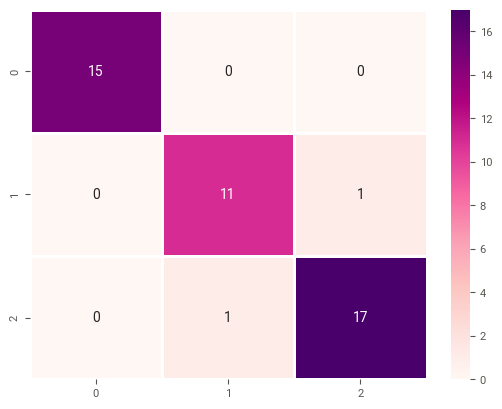

In [17]:
# Defining the Confusion Matrix
lr_conf_mat = confusion_matrix(y_test, log_reg_pred)
lr_conf_mat = pd.DataFrame(lr_conf_mat).reset_index(drop=True)

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(lr_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.2 Decision Tree

In [18]:
# Initializing the model
dt_clf = DecisionTreeClassifier(random_state=24)
dt_model = dt_clf.fit(X_train, y_train)

# Feature importances
dt_importance = dt_model.feature_importances_
dt_importance = pd.DataFrame(dt_importance, columns=["score"]).reset_index()
dt_importance["Feature"] = list(X.columns)
dt_importance.drop(columns=["index"], inplace=True)

dt_importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

# Plotting the feature importances
fig = px.bar(dt_importance, x="Feature", y="score")
fig.show()

In [19]:
# Making predictions
dt_pred = dt_model.predict(X_test)

# Evaluating the model
dt_report = classification_report(y_test, dt_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(dt_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.92      0.96        12
 Iris-virginica       0.95      1.00      0.97        18

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



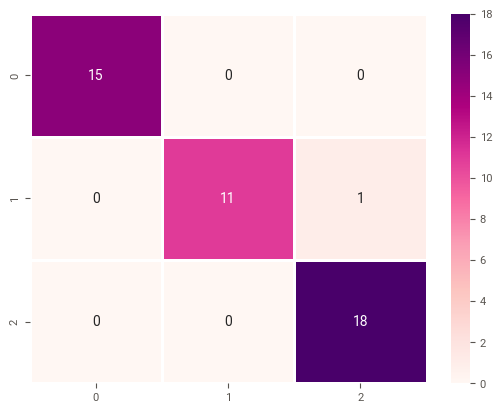

In [20]:
# Defining the Confusion Matrix
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_conf_mat = pd.DataFrame(dt_conf_mat).reset_index(drop=True)

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(dt_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.3 Random Forest

In [21]:
# Random Forests
rf_clf = RandomForestClassifier(random_state=24)
rf_model = rf_clf.fit(X_train, y_train)

# Feature Importance of the Random Forest Model
rf_importance = rf_model.feature_importances_
rf_importance = pd.DataFrame(rf_importance, columns=["score"]).reset_index()
rf_importance["Feature"] = list(X.columns)
rf_importance.drop(columns=["index"], inplace=True)
rf_importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

# Visualizing the feature importances
fig = px.bar(rf_importance, x="Feature", y="score")
fig.show()

In [22]:
# Making predictions
rf_pred = rf_model.predict(X_test)

# Evaluating the model
rf_report = classification_report(y_test, rf_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(rf_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.92      0.92      0.92        12
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



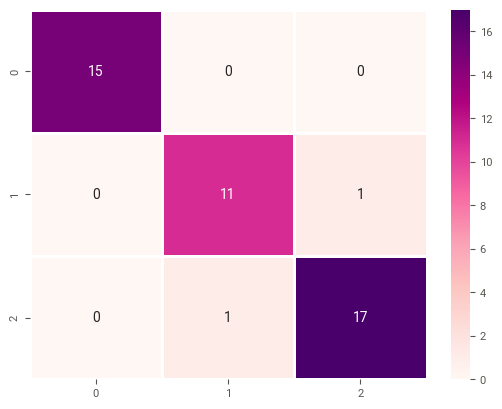

In [23]:
# Defining the Confusion Matrix
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_conf_mat = pd.DataFrame(rf_conf_mat).reset_index(drop=True)

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(rf_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.4 XGBoost

In [24]:
# Fitting model to the training data
xgb_clf = XGBClassifier(random_state=24)
xgb_model = xgb_clf.fit(X_train, y_train)

# Feature Importance of the XGBoost Model
xgb_importance = xgb_model.feature_importances_
xgb_importance = pd.DataFrame(xgb_importance, columns=["score"]).reset_index()
xgb_importance["Feature"] = list(X.columns)
xgb_importance.drop(columns=["index"], inplace=True)
xgb_importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

# Visualizing the feature importances
fig = px.bar(xgb_importance, x="Feature", y="score")
fig.show()

In [25]:
# Making predictions
xgb_pred = xgb_model.predict(X_test)

# Evaluating the model
xgb_report = classification_report(y_test, xgb_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(xgb_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.92      0.96        12
 Iris-virginica       0.95      1.00      0.97        18

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



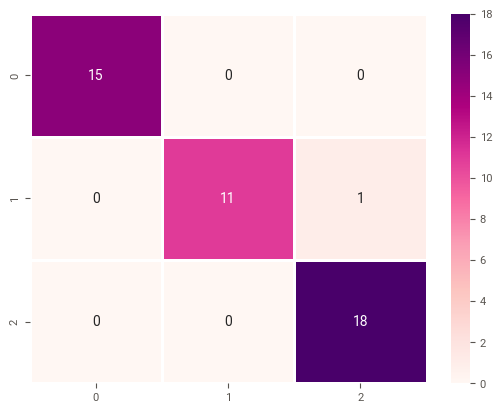

In [26]:
# Defining the Confusion Matrix
xgb_conf_mat = confusion_matrix(y_test, xgb_pred)
xgb_conf_mat = pd.DataFrame(xgb_conf_mat).reset_index(drop=True)
xgb_conf_mat

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(xgb_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.5 CatBoost

In [27]:
# Initializing CatBoostClassifier
catb_clf = CatBoostClassifier(metric_period=100, random_state=24)

# Fitting it to the training data
catb_model = catb_clf.fit(X_train, y_train)

# Feature Importance of the Model
catb_importance = catb_model.feature_importances_
catb_importance = pd.DataFrame(catb_importance, columns=["score"]).reset_index()
catb_importance["Feature"] = list(X.columns)
catb_importance.drop(columns=["index"], inplace=True)
catb_importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

# Visualize the feature importances
fig = px.bar(catb_importance, x="Feature", y="score")
fig.show()

Learning rate set to 0.070535
0:	learn: 1.0235034	total: 136ms	remaining: 2m 15s
100:	learn: 0.0746170	total: 208ms	remaining: 1.85s
200:	learn: 0.0311956	total: 277ms	remaining: 1.1s
300:	learn: 0.0192405	total: 349ms	remaining: 810ms
400:	learn: 0.0137641	total: 418ms	remaining: 625ms
500:	learn: 0.0106780	total: 488ms	remaining: 486ms
600:	learn: 0.0086890	total: 558ms	remaining: 371ms
700:	learn: 0.0073180	total: 627ms	remaining: 267ms
800:	learn: 0.0062957	total: 696ms	remaining: 173ms
900:	learn: 0.0055142	total: 766ms	remaining: 84.2ms
999:	learn: 0.0049153	total: 835ms	remaining: 0us


In [28]:
# Making the predictions
catb_pred = catb_model.predict(X_test)

# Evaluating the model
catb_report = classification_report(y_test, catb_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(catb_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.92      0.92      0.92        12
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



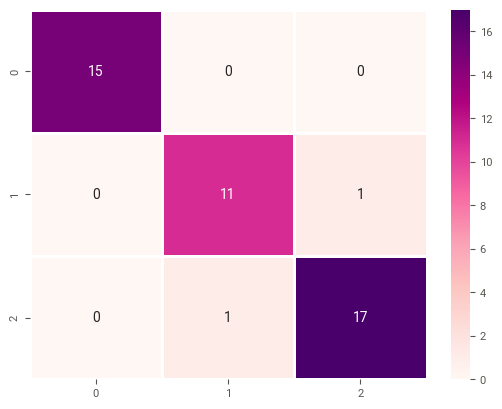

In [29]:
# Defining the Confusion Matrix
catb_conf_mat = confusion_matrix(y_test, catb_pred)
catb_conf_mat = pd.DataFrame(catb_conf_mat).reset_index(drop=True)

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(catb_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.6 LightGBM

In [30]:
# Initializing LightGBM Classifier
lgb_clf = lgb.LGBMClassifier(random_state=24)

# Fitting it to the training data
lgb_model = lgb_clf.fit(X_train, y_train)

# Feature Importance of the Model
lgb_importance = lgb_model.feature_importances_
lgb_importance = pd.DataFrame(lgb_importance, columns=["score"]).reset_index()
lgb_importance["Feature"] = list(X.columns)
lgb_importance.drop(columns=["index"], inplace=True)
lgb_importance.sort_values(by="score", ascending=False, ignore_index=True, inplace=True)

# Visualizing the feature importances
fig = px.bar(lgb_importance, x="Feature", y="score")
fig.show()

In [31]:
# Making the predictions
lgb_pred = lgb_model.predict(X_test)

# Evaluating the model
lgb_report = classification_report(y_test, lgb_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(lgb_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.92      0.96        12
 Iris-virginica       0.95      1.00      0.97        18

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.98        45
   weighted avg       0.98      0.98      0.98        45



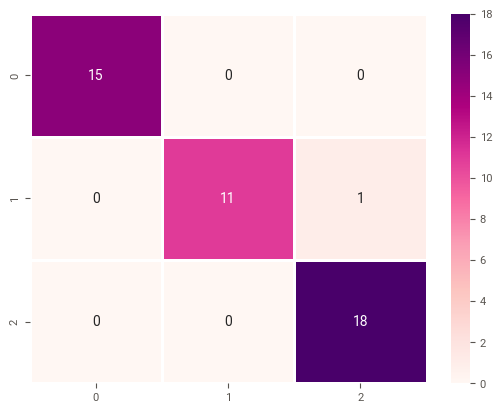

In [32]:
# Defining the Confusion Matrix
lgb_conf_mat = confusion_matrix(y_test, lgb_pred)
lgb_conf_mat = pd.DataFrame(lgb_conf_mat).reset_index(drop=True)

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(lgb_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.xlabel = ("y_pred")
plt.ylabel = ("y_true")
plt.show()

### 5.7 Summarizing the Performance of the Models

In [33]:
# Defining a helper function to evaluate the models at a go
def evaluation(fit_models, X_test, y_test):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)

        lst.append([
            name,
            precision_score(y_test, pred, average="weighted"),
            recall_score(y_test, pred, average="weighted"),
            f1_score(y_test, pred, average="weighted"),
            accuracy_score(y_test, pred)
        ])

    eval_df = pd.DataFrame(lst, columns=["model", "precision", "recall", "f1_weighted", "accuracy"])
    eval_df.set_index("model", inplace=True)
    return eval_df

In [34]:
# Evaluating all the models with the function
all_models = {
    "Logistic Regression": log_reg_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "CatBoost": catb_model,
    "LightGBM": lgb_model
}

all_models_eval = evaluation(all_models, X_test, y_test)
all_models_eval = all_models_eval.sort_values(by=["f1_weighted", "accuracy"], ascending=False)
all_models_eval

precision    recall  f1_weighted  accuracy
model                                                          
Decision Tree         0.978947  0.977778     0.977595  0.977778
XGBoost               0.978947  0.977778     0.977595  0.977778
LightGBM              0.978947  0.977778     0.977595  0.977778
Logistic Regression   0.955556  0.955556     0.955556  0.955556
Random Forest         0.955556  0.955556     0.955556  0.955556
CatBoost              0.955556  0.955556     0.955556  0.955556

**Notes on Features**

From all the models, we note some consistency in the feature importances; in terms of importance (from most to least), the features may be ordered as petal width, petal length, sepal width, and sepal length. This indicates that generally, petal features are better determinants of the specie of an iris flower (based on the models).

## 6.0 Model Optimization: Cross-Validation and Hyperparameter tuning

From Section 5.7 above, we note that the Decision Tree, XGBoost, and LightGBM models were tied at the top for best performing models. The other three were also tied, still with relatively high performance scores.

Based on this, the Decision Tree and XGBoost models will be chosen as the optimal models for further tuning and optimization as they have the highest F1 scores. The high F1 scores may imply that regardless of the weight of the precision and recall, they performs well.

### 6.1 Decision Tree: K-Fold Cross-Validation

**Pasting the model here for ease of access**

*Decision Tree*
```python
dt_clf = DecisionTreeClassifier(random_state=24)
dt_model = dt_clf.fit(X_train, y_train)
```

In [35]:
# Defining the number of folds for cross-validation and the range of estimators
cv = list(range(10, 21, 5))

# Using a loop to cross-validate with each number in the range of estimators
for c in cv:
    score = cross_val_score(estimator= dt_model, X= X_train, y= y_train, cv= c).mean()
    print(f"The average score after cross-validation for the model at {c} folds is:", "{0:.5}".format(score))

The average score after cross-validation for the model at 10 folds is: 0.94182
The average score after cross-validation for the model at 15 folds is: 0.94286
The average score after cross-validation for the model at 20 folds is: 0.94333


### 6.2 XGBoost

*Pasting the model here for ease of access*

**XGBoost Classifier**
```python
xgb_clf = XGBClassifier(random_state=24)
xgb_model = xgb_clf.fit(X_train, y_train)
```

#### 6.2.1 K-Fold Cross-Validation

As was done with the Decision Tree model, the XGBoost Classifier is is cross-validated using K-Fold Cross-Validation with 3 different k-values.

In [36]:
# Defining the number of folds for cross-validation
cv = list(range(10, 21, 5))

# Defining a loop to cross-validate
for c in cv:
    print(f"The model's average score after cross-validation at {c} folds is:")
    score = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=c).mean()
    print("score_" + str(c) + "_folds:", "{0:.5}".format(score))

The model's average score after cross-validation at 10 folds is:
score_10_folds: 0.94273
The model's average score after cross-validation at 15 folds is:
score_15_folds: 0.94286
The model's average score after cross-validation at 20 folds is:
score_20_folds: 0.94167


From the results above, we note that the best performance is at 15 folds.

#### 6.2.2 RandomizedSearch Cross-Validation

In [37]:
# Defining the values for the RandomizedSearchCV
random_grid = {"colsample_bytree": [0.1, 0.3, 0.5, 0.7],
               "learning_rate": [0.1, 0.3, 0.5, 0.7, 1.0],
               "max_depth": [5, 10, 15, 20, 25, 30, 35],
               "booster": ["gbtree", "gblinear", "dart"],
               "n_estimators": [5, 10, 20, 50, 80, 100]
              }

In [38]:
# Running the RandomizedSearch Cross-Validation with the above set of Parameters
xgb_rs_cv_model = RandomizedSearchCV(estimator=xgb_model,
                                     param_distributions=random_grid,
                                     n_iter=30,
                                     cv=15,
                                     random_state=24,
                                     n_jobs=-1)

# Fitting the model to the training data
xgb_rs_cv_model.fit(X_train, y_train)

[13:36:22] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.



RandomizedSearchCV(cv=15,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                                           predictor=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsample_bytree': [0.1, 0.3, 0.5,
                                                             0.7],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1.0],
                                        'max_depth': [5, 10, 15, 20, 25, 30,
                                                      35],
                                        'n_estimators': [5, 10, 20, 50, 80,
                                                         100]},
                   random_state=24)

In [39]:
# Looking at the best combination of hyperparameters for the model
best_params = xgb_rs_cv_model.best_params_
print("The best combination of hyperparameters for the model will be:")
for param_name in sorted(best_params.keys()):
    print(f"{param_name} : {best_params[param_name]}")

The best combination of hyperparameters for the model will be:
booster : gblinear
colsample_bytree : 0.1
learning_rate : 0.7
max_depth : 30
n_estimators : 80


In [40]:
# Looking at the best score for the model during cross-validation
print("The model's cross-validated score with the best combination of hyperparameters is:",
      "{0:.5}".format(xgb_rs_cv_model.best_score_))

The model's cross-validated score with the best combination of hyperparameters is: 0.9619


In [41]:
# Defining the best version of the model with the best parameters
best_xgb_model = XGBClassifier(random_state=24,
                               booster="gbtree",
                               colsample_bytree=0.1,
                               learning_rate=0.5,
                               max_depth=15,
                               n_estimators=50
                               )

In [42]:
# Fitting the model to the training data
best_xgb_model = best_xgb_model.fit(X_train, y_train)

# Predicting the test data
best_xgb_pred = best_xgb_model.predict(X_test)

In [43]:
# Evaluating the model
best_xgb_report = classification_report(y_test, best_xgb_pred, 
                                        target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
print(best_xgb_report)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.83      0.91        12
 Iris-virginica       0.90      1.00      0.95        18

       accuracy                           0.96        45
      macro avg       0.97      0.94      0.95        45
   weighted avg       0.96      0.96      0.95        45



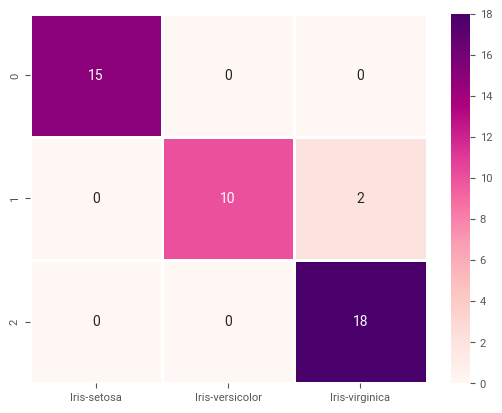

In [44]:
# Confusion Matrix
best_xgb_conf_mat = confusion_matrix(y_test, best_xgb_pred)
best_xgb_conf_mat = (pd.DataFrame(best_xgb_conf_mat).reset_index(drop=True)).rename(columns={0: "Iris-setosa",
                                                                                             1: "Iris-versicolor",
                                                                                             2: "Iris-virginica"})

# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(best_xgb_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.show()

When the confusion matrix after optimization is compared to the original confusion matrix from the original model in Section 5.4, we note that the original model performs better than the optimized model (which is likely overfitting), hence we go with the original model from Section 5.4.

## 7.0 Conclusion

### 7.1 Summary of Key Insights and Recommendations

- Virginicas have the longest sepal lengths, petal lengths and petal widths, while setosas have a wide spread of sepal widths.
- Versicolors lie between setosas and virginicas in all the features.
- In order of importance in predicting a flower's specie the features available may be ordered as petal width, petal length, sepal width, and sepal length. This indicates that generally, petal features are better determinants of the specie of an iris flower (based on the models).
- More observations and features may be needed to increase the ability of machine learning models to predict which specie of Iris a flower belongs to.

### 7.2 Conclusion

Per their confusion matrices, the Decision Tree model and the XGBoost model tie on the performance metrics. As a personal decision, the XGBoost is recommended for further optimization and deployment.

## 10 Exporting

In [45]:
# Exporting the requirements
requirements = "\n".join(f"{m.__name__}=={m.__version__}" for m in globals().values() if getattr(m, "__version__", None))

with open("requirements.txt", "w") as f:
    f.write(requirements)

In [46]:
# Creating a dictionary of objects to export
exports = {"scaler": scaler,
           "model": xgb_model}

In [47]:
# Exporting the dictionary with Pickle
with open("src/Iris_App_toolkit", "wb") as file:
    pickle.dump(exports, file)

In [48]:
# Exporting the model
xgb_model.save_model("src/xgb_model.json")